In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import regularAtlmask

In [2]:
datafolder = ''

In [3]:
experiment = 'Eoi400'
model = 'IPSL-CM5A'
filepath = datafolder+'Raw_data/'+model+'/'

In [4]:
if experiment == 'E280':
    dsT = xr.open_dataset(filepath+experiment+'/IPSLCM5A_piControl_oceTemp_oceSal_V.nc')
    dsV = xr.open_dataset(filepath+experiment+'/IPSLCM5A_piControl_oceTemp_oceSal_V.nc')
    dsS = xr.open_dataset(filepath+experiment+'/IPSLCM5A_piControl_oceTemp_oceSal_V.nc')
    dsice = xr.open_dataset(filepath+experiment+'/PI.Sicfraction_sic_3600_3699_monthly_TS.nc')
    dsr = xr.open_dataset(filepath+'subbasins_orca2.3.P4.nc')
    dsMOC = xr.open_dataset(filepath+experiment+'/IPSLCM5A_piControl_streamfunction_heatTransp.nc')
    dssst = xr.open_dataset(filepath+experiment+'/PI.SeasurfaceTemp_sst_3600_3699_monthly_TS.nc')
else:
    dsV = xr.open_dataset(filepath+experiment+'/IPSLCM5A_Eoi400_oceTemp_oceSal_V.nc', decode_times=False)
    dsT = xr.open_dataset(filepath+experiment+'/IPSLCM5A_Eoi400_oceTemp_oceSal_V.nc', decode_times=False)
    dsS = xr.open_dataset(filepath+experiment+'/IPSLCM5A_Eoi400_oceTemp_oceSal_V.nc', decode_times=False)
    dsice = xr.open_dataset(filepath+experiment+'/Eoi400.Sicfraction_sic_3581_3680_monthly_TS.nc', decode_times=False)
    dsr = xr.open_dataset(filepath+'subbasins_orca2.3.P4.nc')
    dsMOC = xr.open_dataset(filepath+experiment+'/IPSLCM5A_Eoi400_streamfunction_heatTransp.nc', decode_times=False)
    dssst = xr.open_dataset(filepath+experiment+'/Eoi400.Seasurfacetemp_sst_3581_3680_monthly_TS.nc', decode_times=False)

In [5]:
#Do some renaming and transfer temperature field to same grid as region file
dsV = dsV.drop(['deptht','time_counter_bnds'])
dsV = dsV.drop_dims(['deptht'])
dsV = dsV.rename({'nav_lon': 'longitude_u', 'nav_lat': 'latitude_u', 'depthv':'olevel'})

dsr = xr.Dataset(data_vars = dict(Atl=(("y", "x"), dsr.atlmsk.values), Atl_nomed = (("y", "x"), dsr.atlmsk_nomed.values)), coords = dict(latitude =(("y","x"), dsr.navlat.values), longitude = (("y","x"), dsr.navlon.values)))

dsT = dsT.drop(['nav_lon','nav_lat','depthv','time_counter_bnds'])
dsT = dsT.drop_dims(['depthv'])
dsT = dsT.rename({'deptht':'olevel'})
dsT = dsT.assign_coords(dict(latitude=(("y","x"),dsr.latitude.values),longitude=(("y","x"),dsr.longitude.values)))

dsS = dsS.drop_dims(['depthv'])

## Separation MOC and gyre OHT component 100-yr average

In [6]:
temp = dsT.votemper.mean(dim='time_counter')
region = dsr.Atl

#Regrid velocity field to the temperature field, using 0 as a fill value for land to avoid NaN ocean grid cells after interpolation
regridder = xe.Regridder(dsV, dsT, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.vomecrty.mean(dim='time_counter').fillna(0)*100
vvel = regridder(vo) #cm/s
vvel = vvel*temp/temp #Fills land grid cells with NaN again

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Create DXT grid

In [7]:
dphi = np.zeros([149,182])
lat = dsT.latitude.values
dphi[:,1:] = lat[:,1:]-lat[:,:-1]
dphi[:,0] = lat[:,0]-lat[:,-1]
dphi = np.radians(dphi)

dtheta = np.zeros([149,182])
lon = dsT.longitude.values
dtheta[:,1:] = lon[:,1:]-lon[:,:-1]
dtheta[:,0] = lon[:,0]-lon[:,-1]

for j in range(149):
    for i in range(0,182):
        if dtheta[j,i] < -300:
            dtheta[j,i] = dtheta[j,i]+360
dtheta = np.radians(dtheta)

phi1 = np.zeros([149,182])
phi1[:,0] = lat[:,-1]
phi1[:,1:] = lat[:,:-1]
phi1 = np.radians(phi1)

phi2 = np.radians(lat)

r = 6.37122e8 #radius Earth in cm
d = 2*r*np.arcsin(np.sqrt(np.sin(dphi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(dtheta/2)**2)) #Distance between adjacent cells in i dimension on U grid [cm]
dsT['d'] = xr.DataArray(data=d, dims=("j","i")) 
DXT = np.zeros([149,182])
DXT[:,:-1] = (d[:,1:]+d[:,:-1])/2
DXT[:,-1] = (d[:,0]+d[:,-1])/2

dsT['DXT'] = xr.DataArray(data=DXT, dims=("y","x")) #Grid lengths centered on T-points [cm]

Create DZ array

In [8]:
#1-D array with spacing of depth grid
ds = dsT

dz = np.zeros(len(ds.olevel))
dz[0] = ds.olevel[0].values*2
depth = dz[0]
for i in range(1,len(ds.olevel)):
    dz[i] = (ds.olevel[i]-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
dsV['DZ'] = xr.DataArray(data=dz, dims=("olevel"))
dsT['DZ'] = xr.DataArray(data=dz, dims=("olevel"))
DZ = ds.DZ

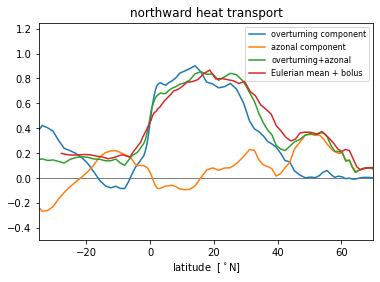

In [9]:
cp_sw = 3996.  # [J/(kg degC)]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

VVEL = vvel.where(region>0) #cm/s
HEAT = (cp_sw*rho_sw*temp).where(region>0)  #  [J/(kg K) * kg/cm^3 * degC] = [J/cm]

def zonal_means(x, dx):
    xint = (x*dx).sum('x')  # [x-unit * cm]
    zm = xint/dx.sum('x')   # [x-unit]
    return xint, zm

#Zonal mean velocity and heat
VVEL_xint, VVEL_zm = zonal_means(VVEL, dsT.DXT.where(VVEL<10000))
HEAT_xint, HEAT_zm = zonal_means(HEAT, dsT.DXT.where(VVEL<10000))

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
HEAT_prime = (HEAT - HEAT_zm) # azonal heat component (x,y,z) [J/cm]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*dsT.DXT*dsT.DZ).sum(dim=['x','olevel'])
Haz = (VVEL_prime*HEAT_prime*dsT.DXT*dsT.DZ).sum(dim=['x','olevel'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

# Auxiliary latitudes for OHT components
lats = dsT.latitude.where(region>0).mean(dim='x')

plt.figure(figsize=(6,4))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Hov/1e15, label='overturning component')

plt.plot(lats, Haz/1e15, label='azonal component')
plt.plot(lats, (Hov+Haz)/1e15, label='overturning+azonal')
plt.plot(dsMOC.lat, dsMOC.sohtatl[:,:,0].mean(dim='time_counter'),label='Eulerian mean + bolus')
#plt.plot(dsovrt.nav_lat.mean(dim='x'), dsovrt.htovovrt[2400:3600, 1, :,0].mean(dim='time'), label = 'Model overturning')
#plt.plot(dsgyre.nav_lat.mean(dim='x'), dsgyre.htovgyre[2400:3600, 1, :,0].mean(dim='time'), label = 'Model gyre')
plt.title('northward heat transport')
plt.xlim([-35,70])
plt.ylim([-0.5, 1.25])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [10]:
dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov[1:-6]/1e15), OHTaz=(["lat"], Haz[1:-6]/1e15)), coords = dict(lat = lats[1:-6].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr average AMOC streamfunction

In [13]:
dsM = xr.Dataset(data_vars = dict(AMOC=(("z","lat"), dsMOC.zomsfatl[:,:,:,0].mean(dim='time_counter').values)), coords = dict(z = dsMOC.depthw.values, lat = dsMOC.lat.values))
xr.Dataset.to_netcdf(dsM, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## 100-yr average total Atlantic OHT

In [14]:
dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), dsMOC.sohtatl[:,:,0].mean(dim='time_counter').values)), coords = dict(lat = dsMOC.lat.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

## 100-yr SSS (regridded)

In [16]:
#Regrid it to the same 1x1 regular grid as other models, take IPSL-CM6A data to provide the structure
model_grid = 'IPSL-CM6A'
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model_grid+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

sss = regridder(dsS.vosaline.mean(dim='time_counter')[0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## Annual SST timeseries (100 years)

In [17]:
#Regrid it to the same 1x1 regular grid as other models, take IPSL-CM6A data to provide the structure
model_grid = 'IPSL-CM6A'
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model_grid+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dssst, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

tos = regridder(dssst.sst)
tosann = np.zeros([100,180,360])

for i in range(0,100):
    tosann[i] = tos[0+i*12:12+i*12].mean(dim='time_counter')

if experiment == 'E280':
    year1 = 3600
    year2 = 3699
else:
    year1 = 3581
    year2 = 3680

dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann)), coords = dict(time = np.arange(year1, year2+1), lat = tos.latitude.values, lon = tos.longitude.values))
xr.Dataset.to_netcdf(dsSST, path = datafolder+'Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

## 100-yr mean sea ice (regridded)

In [19]:
dsi = dsice.drop('time_counter')

djf = (dsi.sic[11:1200:12]+dsi.sic[0:1200:12]+dsi.sic[1:1200:12])/3
djf = djf.mean(dim='time_counter')

mam = (dsi.sic[2:1200:12]+dsi.sic[3:1200:12]+dsi.sic[4:1200:12])/3
mam = mam.mean(dim='time_counter')

jja = (dsi.sic[5:1200:12]+dsi.sic[6:1200:12]+dsi.sic[7:1200:12])/3
jja = jja.mean(dim='time_counter')

son = (dsi.sic[8:1200:12]+dsi.sic[9:1200:12]+dsi.sic[10:1200:12])/3
son = son.mean(dim='time_counter')

#Regrid to regular 1x1, take IPSL-CM6A as structure
model_grid = 'IPSL-CM6A'
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model_grid+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsi, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

si_djf = regridder(djf)*100 #Convert to percentage
si_mam = regridder(mam)*100
si_jja = regridder(jja)*100
si_son = regridder(son)*100

si = (si_djf+si_mam+si_jja+si_son)/4

dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.latitude.values, lon = si_djf.longitude.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'Processed/'+model+'/'+experiment+'/SI_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean top 100 m salinity

In [20]:
def makedz(z):
    dz = np.zeros(len(z))
    dz[0] = z[0].values*2
    depth = dz[0]
    for i in range(1,len(z)):
        dz[i] = (z[i]-depth)*2
        depth = depth+dz[i] #Depth spacing. Units: cm
    return xr.DataArray(data=dz, dims=("deptht"))

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = makedz(dsS.deptht[0:9])

s100m = regridder(dsS.vosaline.mean(dim='time_counter')[0:9].weighted(weights).mean(dim='deptht'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean salinity Atlantic

In [21]:
salt_atl = dsS.vosaline.mean(dim='time_counter')

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model_grid+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.deptht.values, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean temperature Atlantic

In [22]:
temp_atl = dsT.votemper.mean(dim='time_counter')

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model_grid+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

temp_zm = temp.where(mask>-1).mean(dim='longitude')

dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.olevel.values, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [24]:
folder = datafolder+'Raw_data/'+model+'/'

if experiment == 'E280':
    dsu = xr.open_dataset(folder+experiment+'/Atm/piControl_CM5A_ua_va_SE.nc')
else:
    dsu = xr.open_dataset(folder+experiment+'/Atm/Eoi400_CM5A_ua_va_SE.nc')

In [25]:
ua = dsu.ua.mean(dim='time_counter')[0]
va = dsu.va.mean(dim='time_counter')[0]

In [26]:
#Regrid to regular 1x1, use IPSL-CM6A example as structure 
model_grid = 'IPSL-CM6A'
dsgrid = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/'+model_grid+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsu, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
